In [1]:
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
#from utils import helpers
from organelle_heatmap import get_mask, get_average_intensities_cr, get_average_intensities_tsp, correlation
from organelle_heatmap_helpers import get_cells, plot_pilr_collage, plot_image_collage, get_heatmap, sliced_wasserstein

import configs.config as cfg
intensity_sampling_concentric_ring = True
intensity_warping = False #True
cell_line = 'S-BIAD34' #'U2OS' #'Hep-G2' #'U2OS' # 

project_dir = os.path.join(os.path.dirname(cfg.PROJECT_DIR), cell_line)
print('Working dir: ', project_dir)

fft_dir = f"{project_dir}/fftcoefs/{cfg.ALIGNMENT}"
fft_path = os.path.join(fft_dir, f"fftcoefs_{cfg.N_COEFS}.txt")
shape_mode_path = f"{project_dir}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}"
if intensity_sampling_concentric_ring:
    avg_organelle_dir = f"{project_dir}/matrix_protein_avg"
    sampled_intensity_dir = f"{project_dir}/sampled_intensity_bin"
if intensity_warping:
    avg_organelle_dir = f"{project_dir}/warps_protein_avg_cell_pairwise" 
    sampled_intensity_dir = f"{project_dir}/warps" 

Working dir:  /data/2Dshapespace/S-BIAD34


In [2]:
mapping = pd.read_csv(f"{project_dir}/experimentB-processed.txt", sep='\t')
mapping.head(2)

,Antibody id,ENSG,Gene,Gene desc,WellPlate,well,plate,compartment,variance_comp,gini_comp,isKnownCCD,CCD_COMP,nonccd_comp
0,HPA012567,ENSG00000003137,CYP26B1,cytochrome P450 family 26 subfamily B member 1,H04_55195978,H04,55195978,Cyto,"0,000997771","0,343749476",True,True,False
1,HPA043018,ENSG00000003249,DBNDD1,dysbindin domain containing 1,G01_55335984,G01,55335984,Nuc,"0,002558498","0,109944939",False,True,False


In [27]:
mapping[mapping.compartment=='Cyto'].sort_values('Antibody id')

,Antibody id,ENSG,Gene,Gene desc,WellPlate,well,plate,compartment,variance_comp,gini_comp,isKnownCCD,CCD_COMP,nonccd_comp
741,HPA000834,ENSG00000160211,G6PD,glucose-6-phosphate dehydrogenase,B01_55405991,B01,55405991,Cyto,"0,000340109","0,142619286",False,False,True
353,HPA000842,ENSG00000117707,PROX1,prospero homeobox 1,H01_55185977,H01,55185977,Cyto,"2,08E-05","0,130884468",True,False,True
172,HPA001130,ENSG00000100097,LGALS1,galectin 1,C01_55405991,C01,55405991,Cyto,"0,002829972","0,13206366",False,False,True
824,HPA001254,ENSG00000166165,CKB,creatine kinase B,H02_55185977,H02,55185977,Cyto,"1,37E-05","0,169711421",False,True,False
803,HPA001384,ENSG00000165025,SYK,spleen associated tyrosine kinase,B03_55185977,B03,55185977,Cyto,"8,65E-06","0,124020625",True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,HPA070706,ENSG00000115935,WIPF1,WAS/WASL interacting protein family member 1,E06_55395990,E06,55395990,Cyto,"0,00045965","0,12960551",False,False,True
720,HPA071048,ENSG00000157764,BRAF,"B-Raf proto-oncogene, serine/threonine kinase",C07_55395990,C07,55395990,Cyto,"0,000743431","0,185929739",True,True,False
814,HPA074089,ENSG00000165660,ABRAXAS2,"abraxas 2, BRISC complex subunit",G07_55405991,G07,55405991,Cyto,"0,000205806","0,13490424",True,False,True
70,HPA074408,ENSG00000065000,AP3D1,adaptor related protein complex 3 delta 1 subunit,C08_55405991,C08,55405991,Cyto,"0,000176857","0,168094037",False,False,True


# Spatial variation

In [28]:
#from imageio import imread
from skimage.filters import threshold_otsu
def load_pilr(paths):
    avg_cell = []
    for p in paths:
        try:
            img = np.load(p)
            #otsu_thres = threshold_otsu(img)
            #print(img)
            #img = (img >= 0.5).astype(float)
            avg_cell.append(img)
        except:
            print(f'potential empty file: {p}')
    return avg_cell

sc_stats = pd.read_csv(f"{project_dir}/single_cell_statistics_pcs.csv")
sc_stats['Protein_nu_mean'] = sc_stats.Protein_nu_sum / sc_stats.nu_area
sc_stats['Protein_cell_mean'] = sc_stats.Protein_cell_sum / sc_stats.cell_area

res = []
#for ab, tmp in sc_stats.groupby('ab_id'):
if True:
    ab = 'HPA000834'
    tmp = sc_stats[sc_stats.ab_id == ab]
    g0 = tmp[tmp.PC1 == 0].cell_id.unique()
    g1 = tmp[tmp.PC1 == 3].cell_id.unique()
    g2 = tmp[tmp.PC1 == 6].cell_id.unique()
    #avg_protein_g0 = load_pilr([f'{sampled_intensity_dir}/{ab}_{cell_id}_protein.npy' for cell_id in g0])
    #avg_protein_g1 = load_pilr([f'{sampled_intensity_dir}/{ab}_{cell_id}_protein.npy' for cell_id in g1])
    #avg_protein_g2 = load_pilr([f'{sampled_intensity_dir}/{ab}_{cell_id}_protein.npy' for cell_id in g2])
    #wd21 = sliced_wasserstein(np.mean(np.asarray(avg_protein_g2), axis=0), np.mean(np.asarray(avg_protein_g1), axis=0))
    #wd01 = sliced_wasserstein(np.mean(np.asarray(avg_protein_g0), axis=0), np.mean(np.asarray(avg_protein_g1), axis=0))

    avg_protein_g0 = get_average_intensities_cr([f'{ab}_{cell_id}' for cell_id in g0], sampled_intensity_dir=sampled_intensity_dir)
    avg_protein_g1 = get_average_intensities_cr([f'{ab}_{cell_id}' for cell_id in g1], sampled_intensity_dir=sampled_intensity_dir)
    avg_protein_g2 = get_average_intensities_cr([f'{ab}_{cell_id}' for cell_id in g2], sampled_intensity_dir=sampled_intensity_dir)
    wd21 = sliced_wasserstein(avg_protein_g2, avg_protein_g1)
    wd01 = sliced_wasserstein(avg_protein_g0, avg_protein_g1)
    #print(len(g0), len(g1), len(g2))
    res.append([ab, len(g0), len(g1), len(g2), wd21, wd01])

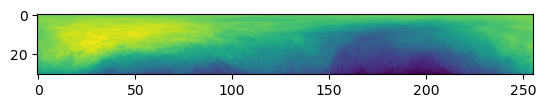

In [29]:
avg_protein_g0 = load_pilr([f'{sampled_intensity_dir}/{ab}_{cell_id}_protein.npy' for cell_id in g1])
plt.imshow(np.mean(np.asarray(avg_protein_g0), axis=0))

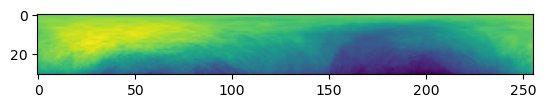

In [30]:
avg_protein_g0 = load_pilr([f'{sampled_intensity_dir}0/{ab}_{cell_id}_protein.npy' for cell_id in g1])
plt.imshow(np.mean(np.asarray(avg_protein_g0), axis=0))

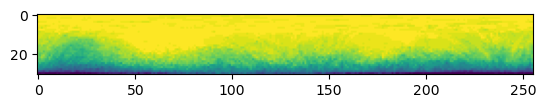

In [16]:
avg_protein_g0 = get_average_intensities_cr([f'{ab}_{cell_id}' for cell_id in g1], sampled_intensity_dir=sampled_intensity_dir)
plt.imshow(avg_protein_g0)

In [17]:
df = pd.DataFrame(res, columns=['ab_id', 'n_g0', 'n_g1', 'n_g2', 'wd21', 'wd01'])
df = df.merge(mapping, left_on='ab_id', right_on='Antibody id')
df.sort_values('wd01', ascending=False).head(10)

,ab_id,n_g0,n_g1,n_g2,wd21,wd01,Antibody id,ENSG,Gene,Gene desc,WellPlate,well,plate,compartment,variance_comp,gini_comp,isKnownCCD,CCD_COMP,nonccd_comp
0,HPA000540,7,35,29,0.041177,0.106616,HPA000540,ENSG00000213190,MLLT11,"MLLT11, transcription factor 7 cofactor",C01_55185977,C01,55185977,Cell,"0,000158389","0,212386249",False,True,False


In [295]:
df[df.compartment == 'Cyto'].sort_values('wd21', ascending=False).head(20)
df[df.Gene=='NKTR']

,ab_id,n_g0,n_g1,n_g2,wd21,wd01,Antibody id,ENSG,Gene,Gene desc,WellPlate,well,plate,compartment,variance_comp,gini_comp,isKnownCCD,CCD_COMP,nonccd_comp
213,HPA022120,15,35,18,0.083997,0.192823,HPA022120,ENSG00000114857,NKTR,natural killer cell triggering receptor,B06_55235979,B06,55235979,Cell,"0,002468944","0,179040754",True,False,True


array([<Axes: title={'center': 'wd21'}>], dtype=object)

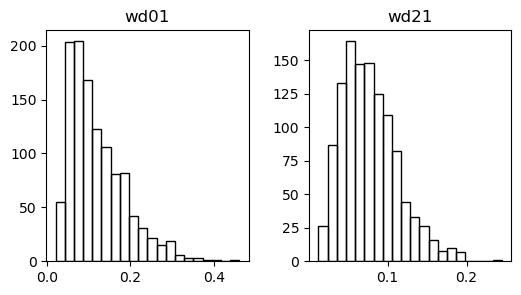

In [238]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
df.hist(column='wd01', fill=False, grid=False, bins=20, ax=ax[0])
df.hist(column='wd21', fill=False, grid=False, bins=20, ax=ax[1])

In [31]:
ab = 'HPA000834'#'HPA007191'#'HPA001218'#'HPA002940'#'HPA061136'#'HPA014711'#'HPA045646' #'HPA022120'#
#tmp = sc_stats[(sc_stats.ab_id == ab) & (sc_stats.GMM_cc_label=='G2')] # 
tmp = sc_stats[sc_stats.ab_id == ab]
g0 = tmp[tmp.PC1.isin([1])].cell_id.unique()
g1 = tmp[tmp.PC1.isin([3])].cell_id.unique()
g2 = tmp[tmp.PC1.isin([6])].cell_id.unique()
avg_protein_g0 = load_pilr([f'{sampled_intensity_dir}/{ab}_{cell_id}_protein.npy' for cell_id in g0])
avg_protein_g1 = load_pilr([f'{sampled_intensity_dir}/{ab}_{cell_id}_protein.npy' for cell_id in g1])
avg_protein_g2 = load_pilr([f'{sampled_intensity_dir}/{ab}_{cell_id}_protein.npy' for cell_id in g2])
paths_g0 = [f'{project_dir}/cell_masks/{ab}/{cell_id}_protein.png' for cell_id in g0]
paths_g1 = [f'{project_dir}/cell_masks/{ab}/{cell_id}_protein.png' for cell_id in g1]
paths_g2 = [f'{project_dir}/cell_masks/{ab}/{cell_id}_protein.png' for cell_id in g2]

In [100]:
sc_stats[sc_stats.ab_id == ab].groupby('GMM_cc').agg({'Protein_nu_mean':'mean','Protein_cell_mean':'mean', 'cell_id': 'count'})

,Protein_nu_mean,Protein_cell_mean,cell_id
GMM_cc,,,
0,9352.602819,5573.469418,92
1,9929.377972,5559.457166,62
2,9825.878995,5719.793207,199


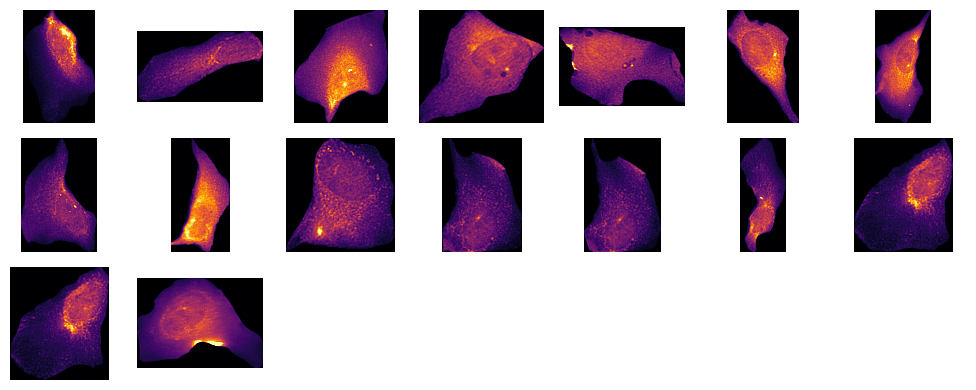

In [43]:
#plot_pilr_collage(paths_g0, n_cols=10)
global_max = 20000
plot_image_collage(paths_g2[:16], n_cols=7, figsize=(10,4), globalvmax=global_max)

Text(0.5, 1.0, 'Group 2')

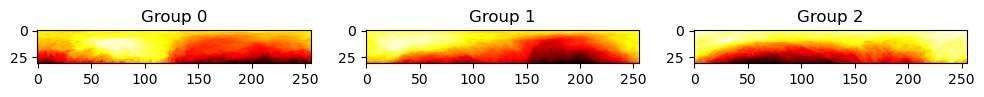

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(np.mean(np.asarray(avg_protein_g0), axis=0), cmap='hot')
ax[0].set_title('Group 0')
ax[1].imshow(np.mean(np.asarray(avg_protein_g1), axis=0), cmap='hot')
ax[1].set_title('Group 1')
ax[2].imshow(np.mean(np.asarray(avg_protein_g2), axis=0), cmap='hot')
ax[2].set_title('Group 2')

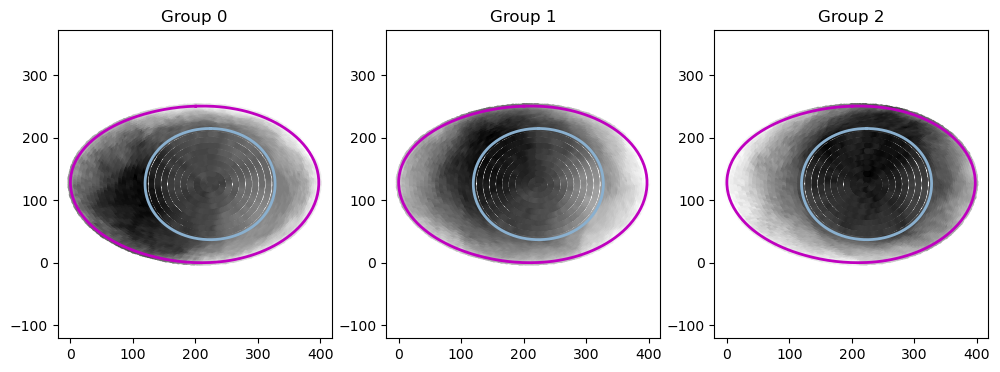

In [34]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
for i, g in zip(range(3), [avg_protein_g0, avg_protein_g1, avg_protein_g2]):
    ax[i].scatter(y.flatten(), x.flatten(), c=np.mean(np.asarray(g), axis=0).flatten(), cmap='binary', s=10) # cmap='gray'
    ax[i].axis('equal')
    ax[i].plot(iy_n, ix_n, "#8ab0cf", linewidth=2)
    ax[i].plot(iy_c, ix_c, 'm', linewidth=2)
    ax[i].set_title(f'Group {i}')

HPA000834 5985_B01_s2_17 /data/2Dshapespace/S-BIAD34/cell_masks/HPA000834/5985_B01_s2_17_protein.png
HPA000834 5985_B01_s2_28 /data/2Dshapespace/S-BIAD34/cell_masks/HPA000834/5985_B01_s2_28_protein.png


/tmp/ipykernel_171286/2005927742.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(paths_g0[10])
/tmp/ipykernel_171286/2005927742.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(paths_g2[13])
/tmp/ipykernel_171286/2005927742.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax[4].imshow(imread(paths_g0[10]), origin='lower', cmap='inferno', vmax=g

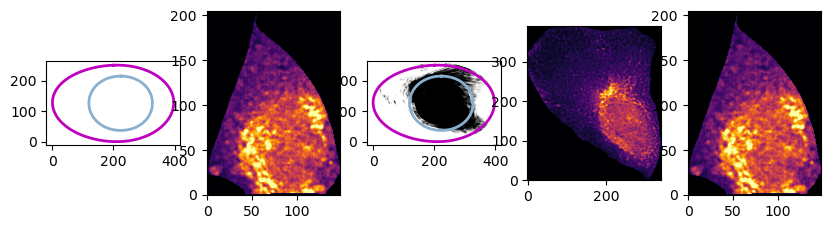

In [52]:
if True:
    from imageio import imread
    global_max = 20000
    fig, ax = plt.subplots(1,5, figsize=(10,3))#, sharex=True, sharey=True)
    pilr = np.load(f'{sampled_intensity_dir}/{ab}_{g0[10]}_protein.npy')
    print(ab, g0[10], paths_g0[10])
    ax[0].scatter(y.flatten(), x.flatten(), c=pilr.flatten(), cmap='binary', s=5)
    #ax[0].imshow(pilr)
    ax[0].axis('scaled')
    ax[0].plot(iy_n, ix_n, "#8ab0cf", linewidth=2)
    ax[0].plot(iy_c, ix_c, 'm', linewidth=2)
    img = imread(paths_g0[10])
    ax[1].imshow(img, origin='lower', cmap='inferno', vmax=global_max)
    #ax[1].imshow(img > 2*threshold_otsu(img), origin='lower', cmap='inferno', vmax=global_max)

    pilr = np.load(f'{sampled_intensity_dir}/{ab}_{g2[13]}_protein.npy')
    print(ab, g2[13], paths_g2[13])
    ax[2].scatter(y.flatten(), x.flatten(), c=pilr.flatten(), cmap='binary', s=5)
    ax[2].axis('scaled')
    ax[2].plot(iy_n, ix_n, "#8ab0cf", linewidth=2)
    ax[2].plot(iy_c, ix_c, 'm', linewidth=2)
    img = imread(paths_g2[13])
    #ax[3].imshow(img > 2*threshold_otsu(img), origin='lower', cmap='inferno', vmax=global_max)
    ax[3].imshow(img, origin='lower', cmap='inferno', vmax=global_max)

    ax[4].imshow(imread(paths_g0[10]), origin='lower', cmap='inferno', vmax=global_max)


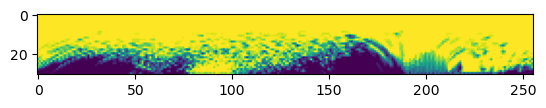

In [37]:
plt.imshow(pilr)

In [23]:
avg_cell = np.load(f"{cfg.PROJECT_DIR}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}/Avg_cell.npz")
nu_centroid = [0, 0]
ix_n = avg_cell["ix_n"]
iy_n = avg_cell["iy_n"]
ix_c = avg_cell["ix_c"]
iy_c = avg_cell["iy_c"]
# Move average shape from zero-centered coords to min=[0,0]
min_x = np.min(ix_c)
min_y = np.min(iy_c)
nu_centroid[0] -= min_x
nu_centroid[1] -= min_y
ix_n -= min_x
iy_n -= min_y
ix_c -= min_x
iy_c -= min_y

from warps import parameterize
x_, y_ = parameterize.get_coordinates(
    np.concatenate([ix_n, iy_n]), 
    np.concatenate([ix_c, iy_c]), 
    nu_centroid, n_isos=cfg.N_ISOS, plot=False
)

x = np.array(x_).round().astype("uint16")
y = np.array(y_).round().astype("uint16")

# Organelle distribution